# Allenamento baseline ResNet50 per Rotazione (Pose Estimation)

Questo notebook permette di:
1. **Import e Setup**
2. **Carica dataset LineMOD**
3. **Inizializza PoseEstimatorBaseline** (ResNet-50 backbone, solo rotazione)
4. **Training**
5. **Valutazione su test set** (solo metriche di rotazione)

## 1. Import e Setup

In [ ]:
import sys
from pathlib import Path
import torch
from torch import optim
import yaml
from pathlib import Path
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

# Importa il config per usare path e file in altre cartelle
sys.path.insert(0, str(Path.cwd().parent))  # Aggiungi parent al path
from config import Config
from dataset.linemod_pose import create_pose_dataloaders
from utils.visualization import plot_training_validation_loss_from_csv, show_pose_samples_with_add, plot_add_per_class, plot_pinhole_error_per_class, calc_add_accuracy_per_class, calc_pinhole_error_per_class
from utils.training import train_pose_baseline
from utils.losses import PoseLossBaseline
from utils.transforms import quaternion_to_rotation_matrix_batch
from utils.metrics import compute_add_batch_rotation_only
from utils.file_io import load_all_models, load_models_info, load_validation_results
from models.pose_estimator_baseline import PoseEstimatorBaseline
from utils.validation import run_pinhole_deep_pipeline


## 2. Carica dataset LineMOD

In [2]:
# Carica i dataloader train, val e test
train_loader, val_loader, test_loader = create_pose_dataloaders(
    dataset_root=Config.LINEMOD_ROOT,
    batch_size=Config.POSE_BATCH_SIZE,
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE,
    num_workers=Config.NUM_WORKERS
)

print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)} | Test batches: {len(test_loader)}")

Train batches: 30 | Val batches: 8 | Test batches: 210


## 3. Inizializza Modello PoseEstimatorBaseline

In [3]:
# Inizializza il modello baseline per la sola rotazione (ResNet-50)
model = PoseEstimatorBaseline(
    pretrained=True,
    dropout=Config.POSE_DROPOUT,
    freeze_backbone=False
).to(Config.DEVICE)

# Mostra info minimali sul modello
params_info = model.get_num_parameters()
print(f"Modello PoseEstimatorBaseline caricato su: {Config.DEVICE}")
print(f"Parametri totali: {params_info['total']:,}")
print(f"Parametri allenabili: {params_info['trainable']:,}")

PoseEstimatorBaseline initialized (BASELINE MODEL)
   Backbone: resnet50 (weights=ResNet50_Weights.IMAGENET1K_V1, frozen=False)
   Feature dim: 2048
   Output: 4 values (quaternion only)
   Translation: Computed with Pinhole Camera Model (NOT learned)
   Dropout: 0.5
Modello PoseEstimatorBaseline caricato su: mps
Parametri totali: 26,136,132
Parametri allenabili: 26,136,132


## 4. Nome e path per allenare-caricare un modello

In [4]:
# Parametri utili anche quando non si fa training
NAME = "pose_rgb_test"

checkpoint_dir = Config.CHECKPOINT_DIR / "pose" / NAME
checkpoint_weights_dir = checkpoint_dir / "weights"
best_path = checkpoint_weights_dir / "best.pt"
last_path = checkpoint_weights_dir / "last.pt"

## 5. Training (solo rotazione)

In [5]:
# Training baseline rotazione (PoseLossBaseline)
EPOCHS = 2#Config.POSE_EPOCHS
LR = Config.POSE_LR
ACCUMULATION_STEPS = Config.ACCUMULATION_STEPS

# Salva args.yaml
args_dict = {
    'epochs': EPOCHS,
    'learning_rate': LR,
    'accumulation_steps': ACCUMULATION_STEPS,
    'batch_size': Config.POSE_BATCH_SIZE,
    'dropout': Config.POSE_DROPOUT,
    'freeze_backbone': False,
    'device': str(Config.DEVICE),
    'crop_margin': Config.POSE_CROP_MARGIN,
    'output_size': Config.POSE_IMAGE_SIZE,
    'weight_decay': Config.POSE_WEIGHT_DECAY
}
# Assicurati che la directory esista prima di salvare il file
checkpoint_dir.mkdir(parents=True, exist_ok=True)
with open(checkpoint_dir / "args.yaml", "w") as f:
    yaml.dump(args_dict, f)

criterion = PoseLossBaseline()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=Config.POSE_WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-7)

history, best_loss, best_epoch = train_pose_baseline(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=Config.DEVICE,
    epochs=EPOCHS,
    accumulation_steps=ACCUMULATION_STEPS,
    checkpoint_dir=str(checkpoint_dir),
    training_config=args_dict,
    save_best=True,
    save_last=True,
    verbose=True
)

print(f"\nBest loss: {best_loss:.4f} @ epoch {best_epoch+1}")
print("✅ Training completato!")

Epoch 1/2: 100%|██████████| 30/30 [00:40<00:00,  1.34s/it, loss=1.9103]


Epoch 1: loss=2.0860, val_loss=1.6657
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_test/weights/best.pt


Epoch 2/2: 100%|██████████| 30/30 [00:32<00:00,  1.10s/it, loss=1.7856]


Epoch 2: loss=1.7420, val_loss=1.4370
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_test/weights/best.pt

Best loss: 1.7420 @ epoch 2
✅ Training completato!


### 5.1 Visualizzazione loss

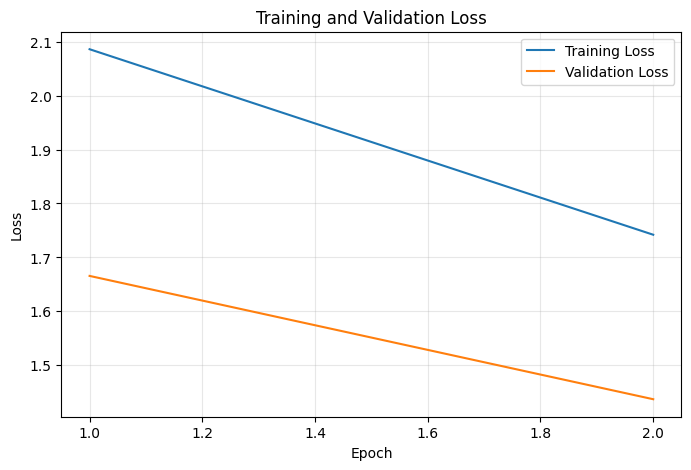

In [6]:
# Plotta la curva di training loss dal CSV
training_csv_path = checkpoint_dir / 'training_result.csv'
plot_training_validation_loss_from_csv(training_csv_path)

## 6. Test e Valutazione su sample del Test Set (solo rotazione)

In [5]:
NAME = "pose_rgb_test"
checkpoint_dir = Config.CHECKPOINT_DIR / "pose" / NAME
checkpoint_weights_dir = checkpoint_dir / "weights"
best_path = checkpoint_weights_dir / "best.pt"
last_path = checkpoint_weights_dir / "last.pt"

### 6.1 Visualizza predizione su batch immagini

✅ Modello pose_rgb_test caricato e in modalità eval!
Batch casuale: estrazione batch random dal dataset di test
Indice di inizio batch casuale: 10576
Numero di sample estratti: 64
Chiavi batch: ['rgb_crop', 'rgb', 'quaternion', 'translation', 'cam_K', 'bbox', 'folder_id', 'sample_id', 'obj_id', 'depth_path', 'rgb_path', 'info_path']

Conversione quaternioni in matrici di rotazione
Carico modelli 3D degli oggetti in memoria.
Questi vengono usati per calcolare la metrica ADD.
Loaded model 01: 5841 points
Loaded model 02: 38325 points
Loaded model 04: 18995 points
Loaded model 05: 22831 points
Loaded model 06: 15736 points
Loaded model 08: 12655 points
Loaded model 09: 7912 points
Loaded model 10: 18473 points
Loaded model 11: 7479 points
Loaded model 12: 15972 points
Loaded model 13: 18216 points
Loaded model 14: 27435 points
Loaded model 15: 16559 points

Calcolo metrica ADD
Test completato su 64 sample

📊 ADD medio sul batch:
   Mean ADD: 54.7060 ± 31.5884


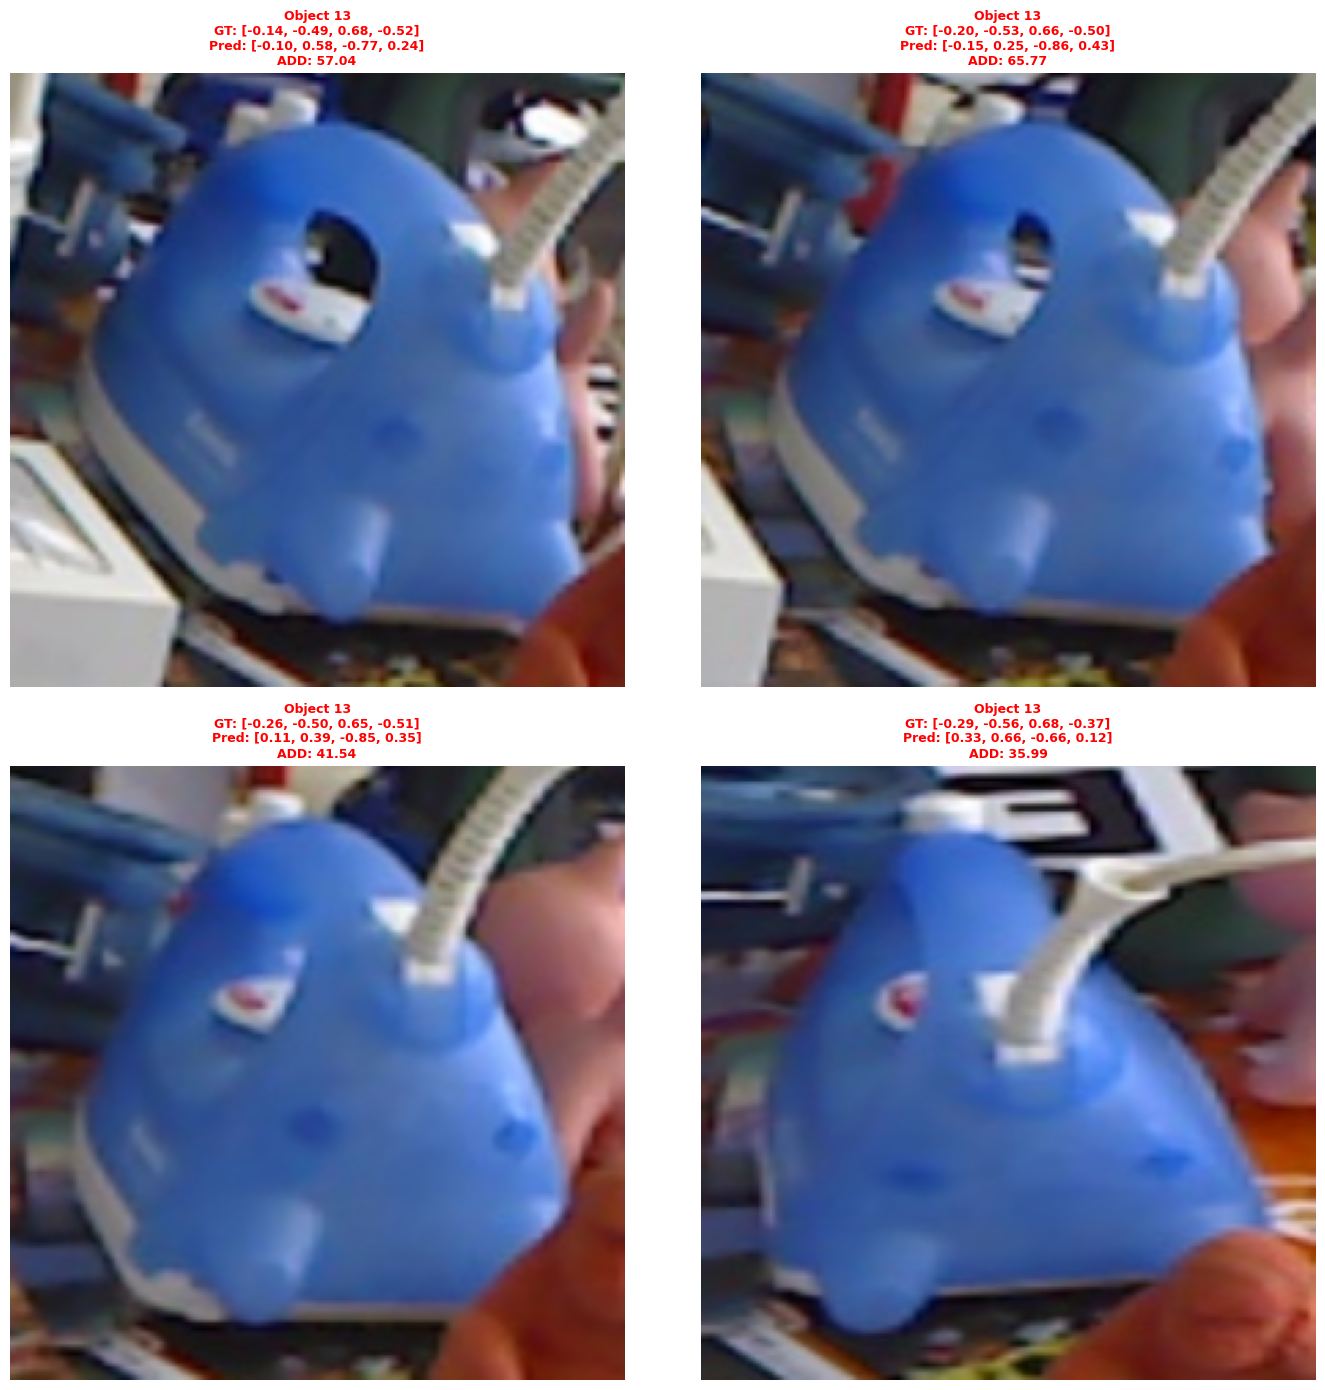

In [6]:
# Carica il modello trained (se necessario)
try:
    model.load_state_dict(torch.load(best_path, map_location=Config.DEVICE))
    model.eval()
    print(f"✅ Modello {NAME} caricato e in modalità eval!")
except Exception as e:
    print(f"⚠️  Modello non trovato o già caricato. Errore: {e}")
    raise SystemExit("Stop right there!")

# Estrai un batch casuale direttamente dal dataset di test
print("Batch casuale: estrazione batch random dal dataset di test")
random_start = random.randint(0, len(test_loader.dataset) - test_loader.batch_size)
print(f"Indice di inizio batch casuale: {random_start}")
indices = list(range(random_start, random_start + test_loader.batch_size)) # lista indici selezionati
samples = [test_loader.dataset[i] for i in indices]
print(f"Numero di sample estratti: {len(samples)}")

# Collate i sample come fa il DataLoader
batch = {}
for k in samples[0]:
    values = [sample[k] for sample in samples]
    if isinstance(values[0], torch.Tensor):
        batch[k] = torch.stack(values)
    else:
        batch[k] = values
print(f"Chiavi batch: {list(batch.keys())}")
test_batch = batch

images = test_batch['rgb_crop'].to(Config.DEVICE)
gt_quaternions = test_batch['quaternion'].to(Config.DEVICE)
obj_ids = test_batch['obj_id']

with torch.no_grad():
    pred_quaternions = model(images)

# Conversione quaternioni in matrici di rotazione
print("\nConversione quaternioni in matrici di rotazione")
pred_R = quaternion_to_rotation_matrix_batch(pred_quaternions)
gt_R = quaternion_to_rotation_matrix_batch(gt_quaternions)

# Calcola la metrica ADD solo rotazione (usa utils.metrics)
models_dict = load_all_models()
models_info = load_models_info(Config.LINEMOD_ROOT / "models" / "models_info.yml")

print("\nCalcolo metrica ADD")
results = compute_add_batch_rotation_only(pred_R, gt_R, obj_ids.cpu().numpy() if hasattr(obj_ids, 'cpu') else obj_ids, models_dict, models_info)

rot_errors = results.get('add_values', None)
print(f"Test completato su {len(images)} sample")
print(f"\n📊 ADD medio sul batch:")
print(f"   Mean ADD: {np.mean(rot_errors):.4f} ± {np.std(rot_errors):.4f}")

# Visualizza 4 sample con errore di rotazione
show_pose_samples_with_add(images, gt_quaternions, pred_quaternions, obj_ids, rot_errors)

### 6.2 Statistiche su intero Test set

In [7]:
# Usa PosePinholeDataset per pipeline pinhole+deep
run_pinhole_deep_pipeline(model, test_loader, NAME)

Model pose_rgb_test loaded
Carico modelli 3D degli oggetti in memoria.
Questi vengono usati per calcolare la metrica ADD.
Loaded model 01: 5841 points
Loaded model 02: 38325 points
Loaded model 04: 18995 points
Loaded model 05: 22831 points
Loaded model 06: 15736 points
Loaded model 08: 12655 points
Loaded model 09: 7912 points
Loaded model 10: 18473 points
Loaded model 11: 7479 points
Loaded model 12: 15972 points
Loaded model 13: 18216 points
Loaded model 14: 27435 points
Loaded model 15: 16559 points


Validazione GT crops (baseline): 100%|██████████| 210/210 [02:56<00:00,  1.19it/s]


Concatenating batches...
Computing metrics: rotation-only ADD, full 6D ADD, pinhole translation error
Metrics computed
Risultati di validazione salvati in /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_test/validation_result.csv


### 6.3 Tabella: Media ADD e Accuracy per Classe

La tabella seguente riporta la media dell'errore ADD e l'accuracy (percentuale di pose corrette) per ciascuna classe (oggetto) del dataset LineMOD.

In [8]:
# Carica risultati validazione dal CSV (se esiste)
checkpoint_dir = Config.CHECKPOINT_DIR / "pose" / NAME
val_csv_path = checkpoint_dir / 'validation_result.csv'
if val_csv_path.exists():
    results_rot_only, results_pinhole = load_validation_results(val_csv_path)
    print(f"✅ Risultati caricati da {val_csv_path}")
else:
    results_rot_only = globals().get('results_rot_only', None)
    results_pinhole = globals().get('results_pinhole', None)
    if results_rot_only is None:
        print("⚠️  Devi prima calcolare la metrica ADD rot-only su tutto il test set e salvare i risultati in 'results_rot_only'.")

✅ Risultati caricati da /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_test/validation_result.csv


In [10]:
# Tabella 1: Performance rotazione (ADD solo rotazione, traslazione dummy)
if results_rot_only is not None:
    data, global_add, global_acc = calc_add_accuracy_per_class(results_rot_only, Config.LINEMOD_OBJECTS, use_6d=True)
    df = pd.DataFrame(data)
    display(df)
    print("\nMedia globale ADD (rot-only):", f"{global_add:.2f}")
    print("Accuracy globale (rot-only) (%):", f"{global_acc:.1f}")

# Tabella 2: Statistiche traslazione pinhole
if results_pinhole is not None:
    data_pinhole, global_pinhole = calc_pinhole_error_per_class(results_pinhole, Config.LINEMOD_OBJECTS)
    df_pinhole = pd.DataFrame(data_pinhole)
    display(df_pinhole)
    print("\nErrore medio pinhole globale (mm):", f"{global_pinhole:.2f}")

# Tabella 3: Performance rotazione + traslazione (ADD full pose)
from utils.visualization import calc_combined_results_per_class
if calc_combined_results_per_class is not None:
    data, global_add, global_acc, global_pinhole = calc_combined_results_per_class(results_rot_only, results_pinhole, Config.LINEMOD_OBJECTS)
    df = pd.DataFrame(data)
    display(df)
    print("\nMedia globale ADD (full pose):", f"{global_add:.2f}")
    print("Accuracy globale (full pose) (%):", f"{global_acc:.1f}")

,Class,ADD 6D (mm),Accuracy (%)
0,01 - ape,28.48,7.2
1,02 - benchvise,65.10,9.3
2,04 - camera,70.86,2.2
3,05 - can,66.00,5.3
4,06 - cat,40.54,13.7
5,08 - driller,72.98,4.3
6,09 - duck,36.89,6.2
7,10 - eggbox,7.92,100.0
8,11 - glue,11.12,92.9
9,12 - holepuncher,43.48,7.2



Media globale ADD (rot-only): 50.02
Accuracy globale (rot-only) (%): 21.6


,Class,Pinhole Error (mm)
0,01 - ape,12.13
1,02 - benchvise,28.73
2,04 - camera,26.16
3,05 - can,19.49
4,06 - cat,16.02
5,08 - driller,27.68
6,09 - duck,14.44
7,10 - eggbox,30.27
8,11 - glue,18.32
9,12 - holepuncher,15.01



Errore medio pinhole globale (mm): 22.33


,Class,ADD 6D (mm),Accuracy (%),Pinhole Error (mm)
0,01 - ape,28.48,7.2,12.13
1,02 - benchvise,65.10,9.3,28.73
2,04 - camera,70.86,2.2,26.16
3,05 - can,66.00,5.3,19.49
4,06 - cat,40.54,13.7,16.02
5,08 - driller,72.98,4.3,27.68
6,09 - duck,36.89,6.2,14.44
7,10 - eggbox,7.92,100.0,30.27
8,11 - glue,11.12,92.9,18.32
9,12 - holepuncher,43.48,7.2,15.01



Media globale ADD (full pose): 50.02
Accuracy globale (full pose) (%): 21.6


### 6.4 Grafico: Media ADD per Classe

Il grafico seguente mostra la media dell'errore ADD per ciascuna classe, per un confronto visivo immediato delle performance del modello sui diversi oggetti.

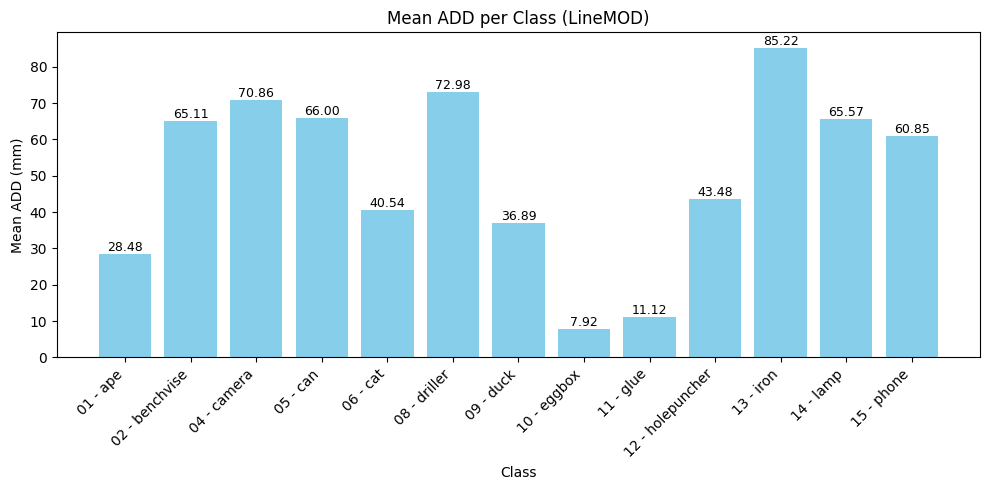

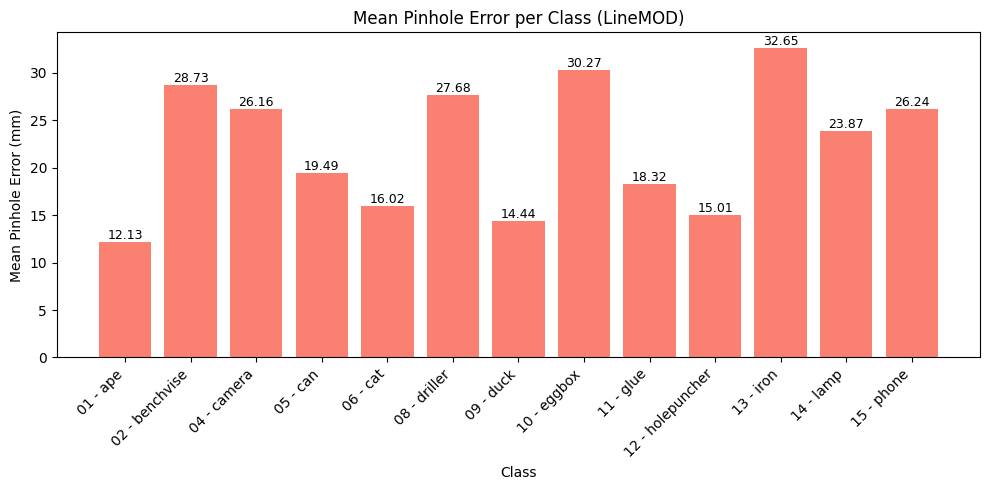

In [11]:
# Grafico a barre delle medie ADD per classe (rot-only)
results_rot_only = globals().get('results_rot_only', None)
if results_rot_only is None:
    print("⚠️  Devi prima calcolare la metrica ADD rot-only su tutto il test set e salvare i risultati in 'results_rot_only'.")
else:
    plot_add_per_class(results_rot_only, Config.LINEMOD_OBJECTS)

# Grafico a barre dell'errore medio pinhole per classe
results_pinhole = globals().get('results_pinhole', None)
if results_pinhole is None:
    print("⚠️  Devi prima calcolare le statistiche di traslazione pinhole e salvarle in 'results_pinhole'.")
else:
    plot_pinhole_error_per_class(results_pinhole, Config.LINEMOD_OBJECTS)